In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import warnings
from post_processing_multi import * # Import data post processing functions
from plotting_helper import * # Import helper functions for plotting in ipynb
warnings.filterwarnings('ignore') # supress warnings for clenliness

# Loading data
Data is provided in a folder (or series of folders) and is loaded and processed with budget assignment by the ```load_multiple_files_budget``` function. This is wrapped in the load_max_cut_data. This takes a long time due to the large number of files that needs to be processed. If data were stored differently (i.e. in a database), this would be much faster. 

In [2]:

if Path("./MaxCut_runs/filtered_dfk.pkl").is_file():
    maxcut_df=pd.read_pickle('./MaxCut_runs/filtered_df.pkl') 
else:
    maxcut_df = load_all_data() #Only load data from files if there is no database
    maxcut_df.to_pickle('./MaxCut_runs/filtered_df.pkl') 
    maxcut_df.to_csv('./MaxCut_runs/filtered_df.csv')


Qubit: 4, depth: 0, budget:0
Qubit: 4, depth: 0, budget:1

Qubit: 6, depth: 0, budget:0
Qubit: 6, depth: 0, budget:1

Qubit: 8, depth: 0, budget:0
Qubit: 8, depth: 0, budget:1

Qubit: 10, depth: 0, budget:0
Qubit: 10, depth: 0, budget:1


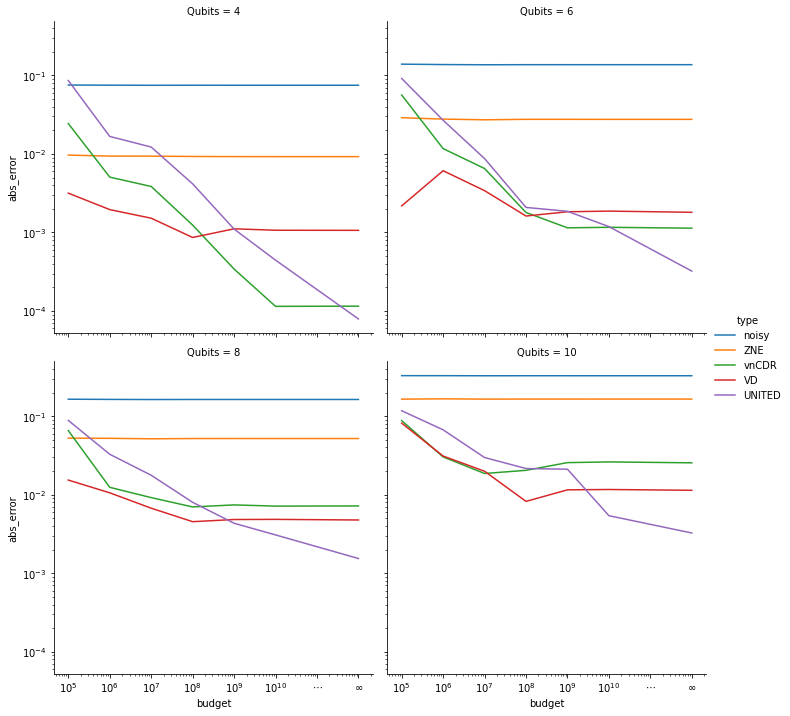

In [4]:
plot_over_budget(maxcut_df)

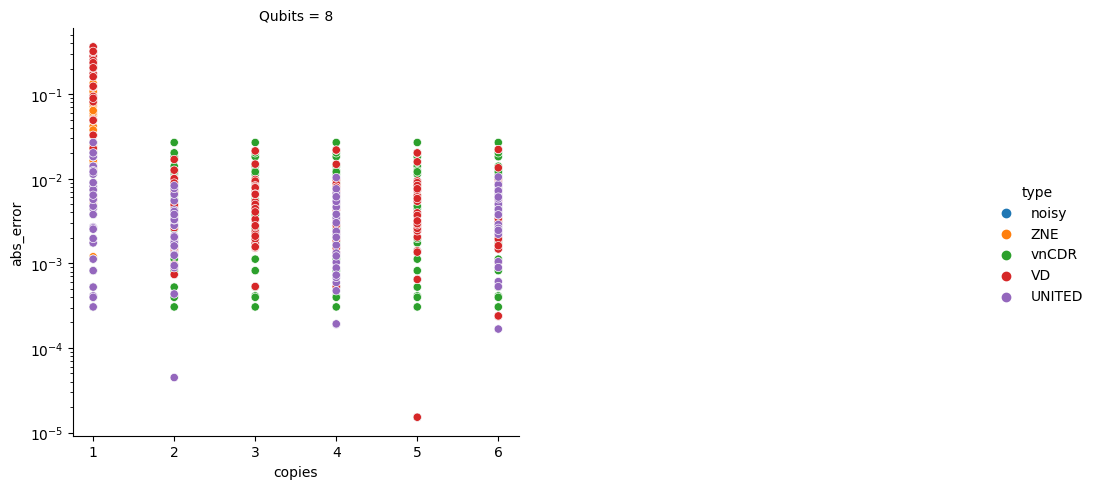

In [28]:
df=t.query('budget==10**')
zero_copy_methods = df.query(
    'abs_error > 0   & nlsp==1 & description == "3nlsp_full" & res_type=="abs_error" & ( type == "ZNE" | type == "vnCDR")'
)
noisy = df.query(
    'abs_error > 0   & nlsp==1 & description == "3nlsp_full" & res_type=="abs_error" & ( type=="VD")'
)
few_copy_methods = df.query(
    'abs_error >  0  & nlsp==1  & description == "3nlsp_full" & res_type=="abs_error" & ( type=="VD")'
)
many_copy_methods = df.query(
    'abs_error > 0  &nlsp==1  & description == "3nlsp_full" & res_type=="abs_error" & ( type=="UNITED")'
)
noisy["type"] = "noisy"
plot_df = pd.concat(
    [noisy, zero_copy_methods, few_copy_methods, many_copy_methods],
    axis=0,
    ignore_index=True,
)
fig = sns.relplot(
    data=plot_df.reset_index(),
    kind="scatter",
    x="copies",
    y="abs_error",
    hue="type",
    col="Qubits",
    col_wrap=2,
    estimator="mean",
    markers=True,
    ci=None,
).set(yscale="log")

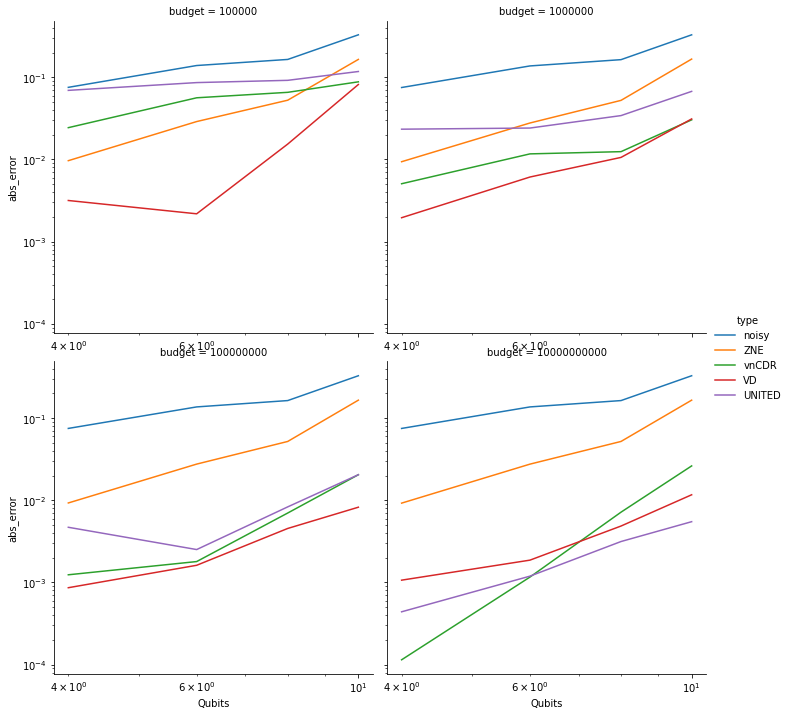

In [16]:
df = maxcut_df.query('budget>0&budget<10**11&budget!=10**9&budget!=10**7')
zero_copy_methods = df.query(
    'abs_error > 0  & copies == 1 & nlsp==1 & description == "3nlsp_full" & res_type=="abs_error" & ( type == "ZNE" | type == "vnCDR")'
)
noisy = df.query(
    'abs_error > 0  & copies == 1 & nlsp==1 & description == "3nlsp_full" & res_type=="abs_error" & ( type=="VD")'
)
few_copy_methods = df.query(
    'abs_error >  0  & nlsp==1 & copies==2 & description == "3nlsp_full" & res_type=="abs_error" & ( type=="VD")'
)
many_copy_methods = df.query(
    'abs_error > 0  &nlsp==1  & copies==4& description == "3nlsp_full" & res_type=="abs_error" & ( type=="UNITED")'
)
noisy["type"] = "noisy"
plot_df = pd.concat(
    [noisy, zero_copy_methods, few_copy_methods, many_copy_methods],
    axis=0,
    ignore_index=True,
)
fig = sns.relplot(
    data=plot_df.reset_index(),
    kind="line",
    x="Qubits",
    col='budget',
    col_wrap=2,
    y="abs_error",
    hue="type",
    estimator="mean",
    markers=True,
    ci=None,
).set(yscale="log", xscale='log')

In [28]:
fig3 = plot_df.groupby(['type','Qubits','budget','copies']).aggregate('max').reset_index().drop(['copies','nlsp','depth'],axis=1).reset_index()


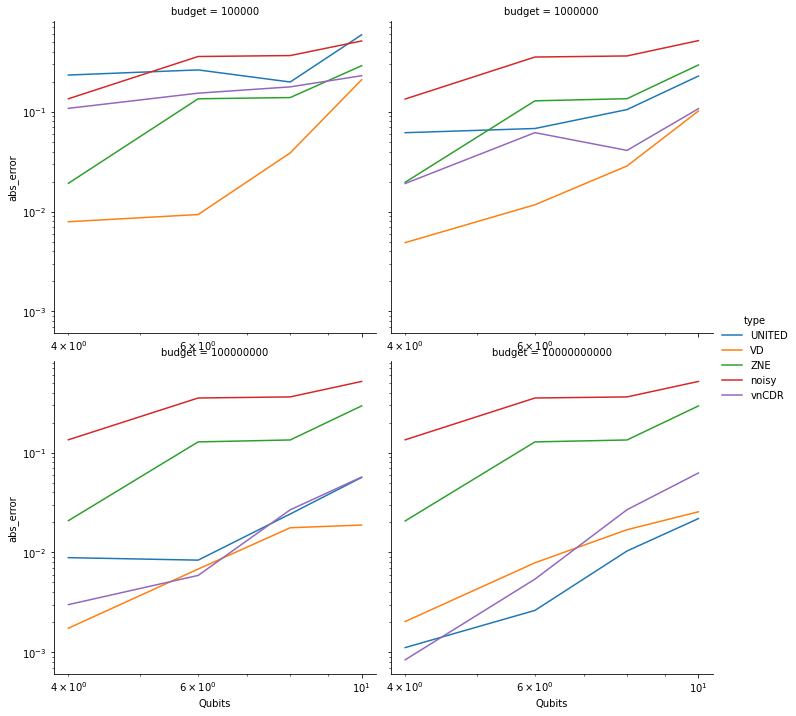

In [30]:
fig = sns.relplot(
    data=fig3.reset_index(),
    kind="line",
    x="Qubits",
    col='budget',
    col_wrap=2,
    y="abs_error",
    hue="type",
    estimator="mean",
    markers=True,
    ci=None,
).set(yscale="log", xscale='log')

In [5]:
import os 
dir_path = 'RQC_runs/all_qubits/'
res = []
for file in os.listdir(dir_path):
    if file.endswith('.pkl'):
        res.append(pd.read_pickle(dir_path+file))
res = pd.concat(res)

In [5]:
def relative_shots(training_sets, noise_levels, max_copies, shots_budget):
    """Returns relative shots with less shots for COI when shots budget is high enough.

    Args:
        training_sets (int): number of training sets.
        noise_levels (int):  number of  noise levels
        max_copies (int): number of copies considred
        shots_budget (int): total budget

    Returns:
        pandas DF: dataframe with shot budgets
    """
    if shots_budget != 0:
        CDR_shots = shots_budget // training_sets
        vnCDR_shots = CDR_shots // noise_levels
        CGVD_shots = shots_budget // training_sets
        storage = pd.DataFrame(
            {
                "VD": [shots_budget // 2] * (max_copies),
                "ZNE": [shots_budget // 2] + [shots_budget // 4] * (max_copies - 1),
                "CDR": [CDR_shots] + [CDR_shots // 2] * (max_copies - 1),
                "vnCDR": [vnCDR_shots] * (max_copies),
                "CGVD": [
                    base_cost // (copy + 2) // 2
                    for copy, base_cost in enumerate([CGVD_shots] * (max_copies))
                ],
                "UNITED": [
                    x // noise_levels
                    for x in [
                        base_cost // (copy + 2)
                        for copy, base_cost in enumerate([CGVD_shots] * (max_copies))
                    ]
                ],
                "copies": list(range(1, max_copies + 1)),
            }
        )
    else:
        storage = pd.DataFrame(
            {
                "VD": None,
                "ZNE": None,
                "CDR": [None] * 6,
                "vnCDR": [None] * 6,
                "CGVD": [None] * 6,
                "UNITED": [None] * 6,
                "copies": list(range(1, max_copies + 1)),
            }
        )
    return pd.melt(storage, id_vars=("copies"))

relative_shots(100,3,6,10**8)

,copies,variable,value
0,1,VD,50000000
1,2,VD,50000000
2,3,VD,50000000
3,4,VD,50000000
4,5,VD,50000000
5,6,VD,50000000
6,1,ZNE,50000000
7,2,ZNE,25000000
8,3,ZNE,25000000
9,4,ZNE,25000000


In [185]:
import os 
dir_path = 'RQC_runs/all_qubits/'
def quick_load(fi):
    res = []
    files = []
    for file in os.listdir(dir_path):
        if file.endswith('.pkl') and file.startswith(f"pandas_{fi}"):
            res.append(pd.read_pickle(dir_path+file).assign(file=file).assign(data=fi))
            files.append(file)
    res = pd.concat(res)
    res=res.reset_index()
    res = res.reset_index().query('copies==1 & nlsp==1')
    res = res.drop(['shots','result_type','copies'],axis=1)
    res["exact"] = pd.to_numeric(res['exact'])
    res["expectation"] = pd.to_numeric(res['expectation'])
    res["exact_abs"] = np.abs(res['exact'])
    return res

train = quick_load('train')
coi = quick_load('COI')

In [187]:
train.groupby('file')['exact_abs'].describe().reset_index().to_csv('train_quick_stats.csv')
coi.groupby('file')['exact_abs'].describe().reset_index().to_csv('coi_quick_stats.csv')


In [5]:
sns.displot(kind='hist',data=pd.concat([coi,train]).query("file.str.contains('4p4')"),x='exact',col='data',col_wrap=4,bins=25,facet_kws=dict(sharey=True)).set(yscale='log')

NameError: name 'coi' is not defined

In [199]:
npcoi = coi.query("file.str.contains('4p4')")['exact'].reset_index()
nptrain = train.query("file.str.contains('4p4')")['exact'].reset_index()

In [3]:
def plot_over_budget(df):
    zero_copy_methods = df.query(
        'abs_error > 0  & copies == 1 & nlsp==1 & description == "3nlsp_full" & res_type=="abs_error" & ( type == "ZNE" | type == "vnCDR")'
    )
    noisy = df.query(
        'abs_error > 0  & copies == 1 & nlsp==1 & description == "3nlsp_full" & res_type=="abs_error" & ( type=="VD")'
    )
    few_copy_methods = df.query(
        'abs_error >  0  & nlsp==1 & copies==2 & description == "3nlsp_full" & res_type=="abs_error" & ( type=="VD")'
    )
    many_copy_methods = df.query(
        'abs_error > 0  &nlsp==1  & copies==3 & description == "3nlsp_full" & res_type=="abs_error" & ( type=="UNITED")'
    )
    noisy["type"] = "noisy"
    plot_df = pd.concat(
        [noisy, zero_copy_methods, few_copy_methods, many_copy_methods],
        axis=0,
        ignore_index=True,
    )
    fig = sns.relplot(
        data=plot_df.reset_index(),
        kind="line",
        x="budget",
        y="abs_error",
        hue="type",
        col="Qubits",
        col_wrap = 2,
        estimator="mean",
        markers=True,
        ci=None,
    ).set(yscale="log", xscale="log")
    ax = fig.axes[0]
    xticks = ax.get_xticks().tolist()
    for i in range(len(xticks) - 1):
        xticks[i] = rf"$10^{{{i+3}}}$"
    xticks[-3] = r"$\infty$"
    xticks[-4] = r"$\cdots$"
    ax.set_xticklabels(xticks)
    return fig
